# Musx-images part 2: Wanderers

In [1]:
%reload_ext autoreload
%autoreload 2

import musx

# Loading a file from one directory up
import sys
sys.path.insert(0, '..') 
import musx_images

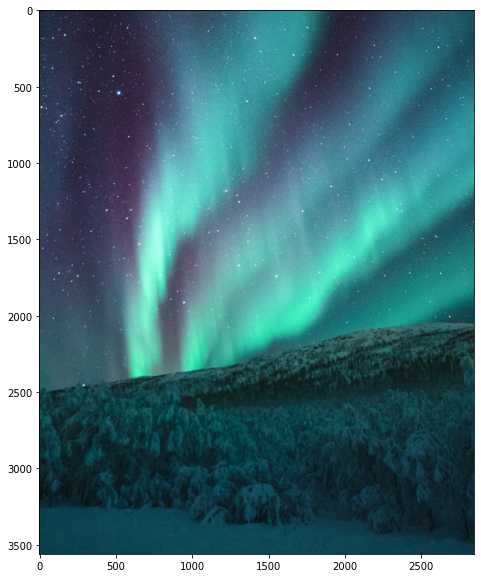

In [2]:
image = musx_images.load_image("../images/northern_lights.jpg")
musx_images.display_image(image)

## Messing with color spaces
We've already seen `convert_image(image, color_space)`, and when it assumes that the photo incoming is RGB it leads to some pretty cool visualizations. Even crazier yet is `randomize_color_space(image, iterations)`, which mangles the image's colorspace by repeatedly sending it through transforms that originally assume that the image is BGR and not what it actually is. There is an optional argument `final_color_space` to specify what color space to end on, but it will still be fairly nonsensical.

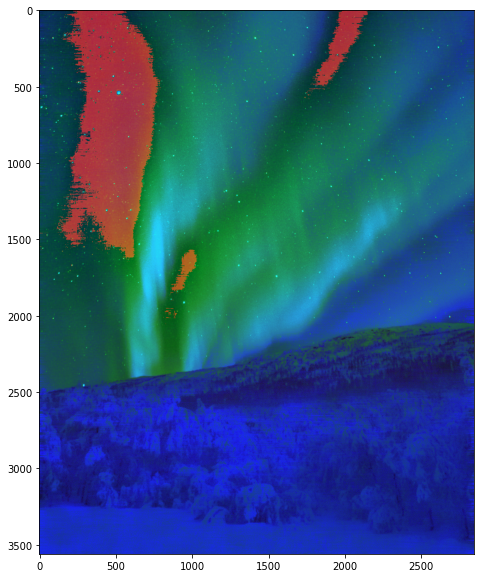

In [3]:
image_hls = musx_images.convert_image(image, color_space="HLS")
musx_images.display_image(image_hls)

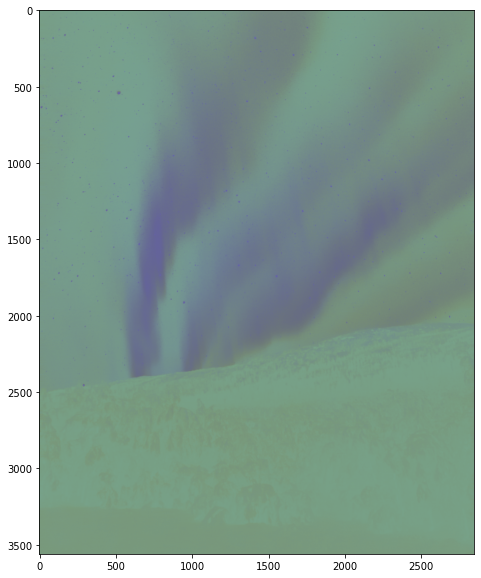

In [4]:
image_random = musx_images.randomize_color_space(image, 5)
musx_images.display_image(image_random)

## Multiple 2D generators at once

Musx can support more that one generator playing at once, as well as 16 different MIDI channels. Below is a string quartet of sorts, that utilizes the `drunk_2d()` generator to make each player do a walk on the image starting from the center. The musical "engine" is the same as the one found in the Image Triads example.

In [5]:
def wanderer(queue, chan, image, notes, length, rhy, amp=0.5, stride_size=50):
    drunk_gen = musx_images.drunk_2d(image, start_row=round(image.shape[0] / 2), start_col=round(image.shape[1] / 2), width=(stride_size, stride_size), movement_2d=False, mode="reflect")
    rhythms = musx.choose([0, rhy/4, rhy/2, [0, rhy/2], [0, rhy/4, rhy/2, 3 * (rhy/4)], [0, 3 * (rhy/4)]])

    for _ in range(length):
        triad_raw, location = next(drunk_gen)
        points.append(location)
        
        triad = map(lambda x : notes[round(musx.rescale(x, 0, 255, 0, len(notes) - 1))], triad_raw)
        for note_num in triad:
            r = next(rhythms)
            if musx.isnum(r):
                queue.out.addevent(musx.MidiNote(time=queue.now, dur=rhy - r, key=note_num, amp=amp, chan=chan))
            else:
                deltas = musx.deltas(r + [rhy])
                for ind, time in enumerate(r):
                    queue.out.addevent(musx.MidiNote(time=queue.now + time, dur=deltas[ind], key=note_num, amp=amp, chan=chan))
        yield rhy

In [6]:
t0 = musx.MidiSeq.metaseq(ins={0: musx.midi.gm.Violin, 1: musx.midi.gm.Viola, 2: musx.midi.gm.Cello, 3: musx.midi.gm.PizzicatoStrings})
t1 = musx.MidiSeq()

queue = musx.Scheduler(out=t1)

musx_images.clear_points_cache()

queue.compose([
    [0, wanderer(queue, 3, image_random, musx.scale(60, 15, 2, 1, 2, 2, 1, 2, 2), 100, 1, stride_size=250)],
    [16, wanderer(queue, 0, image_random, musx.scale(48, 15, 2, 1, 2, 2, 1, 2, 2), 84, 1, 0.35, stride_size=250)],
    [32, wanderer(queue, 1, image_random, musx.scale(60, 15, 2, 1, 2, 2, 1, 2, 2), 68, 1, 0.25,stride_size=250)],
    [32, wanderer(queue, 2, image_random, musx.scale(36, 15, 2, 1, 2, 2, 1, 2, 2), 68, 1, 0.45, stride_size=250)],
])

musx.MidiFile("wanderers.mid", [t0, t1]).write()
# Use Fluidsynth or some other software to play

Done!


<MidiFile: 'wanderers.mid' 0x7f8435b78910>

## Plotting multiple 2D generators at once

Because the `points_cache` persists between calls as it is not reset manually, this enables us to plot all four generators at the same time!

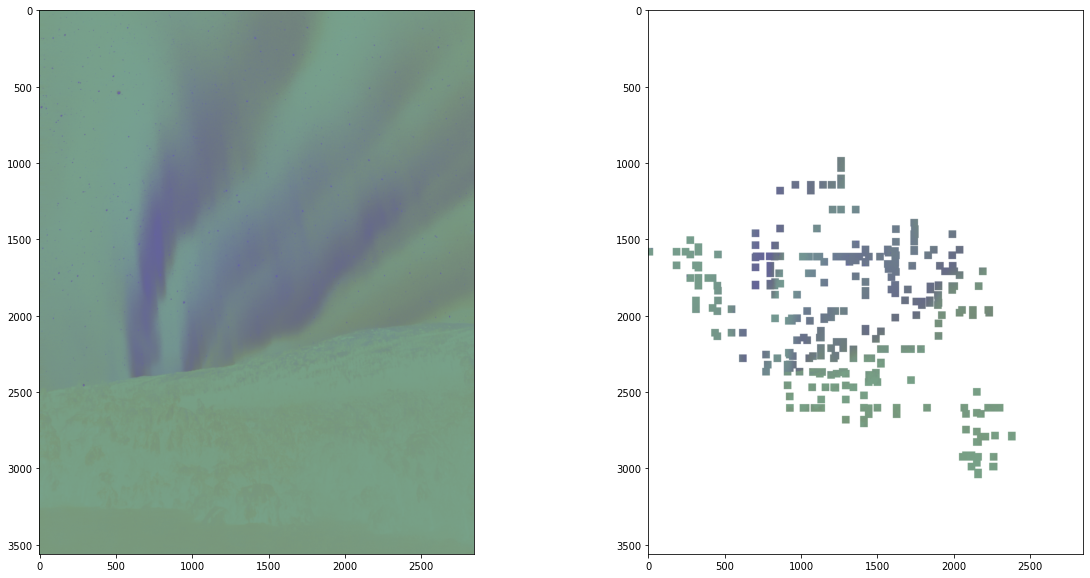

In [7]:
points_image = musx_images.points_image(image_random, musx_images.points_cache)
musx_images.display_images([image_random, points_image])